# EEG ChildMind Dataset Analysis

This notebook takes data from ChildMind and finds correlations between neural spectral parameters ratio measures and age.


In [1]:
import sys
sys.path.append('../bratios')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import pearsonr, spearmanr
import csv
import mne
import seaborn as sns
#sns.set_context('poster')
pd.set_option('display.max_columns', 500)

from fooof import FOOOF, FOOOFGroup
from fooof.analysis import *
from fooof.sim import *
from fooof.data import FOOOFResults
from fooof.funcs import average_fg
from fooof.bands import Bands

from ratios import *
from analysis import *
from settings import *

In [10]:
gen_interacting_per_per("High_CF", "Low_PW", "awf")

[[[1.01250551 0.66536483 0.49491183 ... 0.02026163 0.02016575 0.02074192]
  [1.00134805 0.6720382  0.49125696 ... 0.02042706 0.02044761 0.02014007]
  [0.99936684 0.68311255 0.49738464 ... 0.02009759 0.02017629 0.01989044]
  ...
  [1.00402646 0.66898021 0.50089942 ... 0.02054971 0.02055352 0.02003673]
  [1.00421969 0.6733965  0.50544509 ... 0.02027165 0.02067286 0.02022407]
  [0.99768988 0.6762506  0.5065273  ... 0.02053832 0.02032983 0.02001352]]

 [[1.01295496 0.66284677 0.49357474 ... 0.02013551 0.02026022 0.02037897]
  [0.99123824 0.65868117 0.50888743 ... 0.02051752 0.02001422 0.02024091]
  [0.99904849 0.66180862 0.50498264 ... 0.02043342 0.0197414  0.02017284]
  ...
  [1.01213706 0.68224427 0.50545311 ... 0.02038537 0.02011836 0.02003589]
  [1.01630417 0.66588158 0.49477503 ... 0.0201348  0.0202596  0.02014681]
  [0.97689738 0.66902574 0.4991655  ... 0.0205348  0.02013844 0.02003355]]

 [[0.98861317 0.65925449 0.5011461  ... 0.02075223 0.01999177 0.02010861]
  [0.99220131 0.657728

## Import Data

Here we import power spectra and select channel clusters from the EEG motage used.

In [3]:
# Open Power spectrum
data = pd.read_csv("../dat/MIPDB_PublicFile.csv")

In [4]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../dat/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

In [5]:
all_chans = mne.pick_channels(montage.ch_names,[])

In [6]:
# Define a channel cluster of interest
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']

# Get the indices of the channels of interest
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)

In [7]:
ch_interest = ch_cluster_central+ch_cluster_frontal+ch_cluster_parietal
#ch_interest = mne.pick_channels(montage.ch_names, ch_interest)
montage.selection = ch_interest

# Correlation between Parameters and Theta Beta Ratio

Below we run our data through a process which returns a dataframe where each row is a specific channel from a subject. Columns include spectral parameters for alpha, beta, and theta oscillations as well as theta/beta ratio, theta/alpha ratio, and alpha/beta ratio.

In [6]:
df = get_all_data(data, all_chans)
df.to_csv("../dat/child_mind_data")
df

FileNotFound or ValueError:  A00052593
FileNotFound or ValueError:  A00053398
IndexError:  A00053480
FileNotFound or ValueError:  A00054122
IndexError:  A00054239
FileNotFound or ValueError:  A00054359
FileNotFound or ValueError:  A00054469
FileNotFound or ValueError:  A00054488
FileNotFound or ValueError:  A00054666
FileNotFound or ValueError:  A00054836
FileNotFound or ValueError:  A00054866
FileNotFound or ValueError:  A00055623
FileNotFound or ValueError:  A00055628
FileNotFound or ValueError:  A00055801
FileNotFound or ValueError:  A00055923
FileNotFound or ValueError:  A00056116
FileNotFound or ValueError:  A00056158
LinAlgError:  A00056428
FileNotFound or ValueError:  A00056640
FileNotFound or ValueError:  A00056716
FileNotFound or ValueError:  A00056733
FileNotFound or ValueError:  A00056913
FileNotFound or ValueError:  A00056990
FileNotFound or ValueError:  A00057135
FileNotFound or ValueError:  A00062029
FileNotFound or ValueError:  A00062055
FileNotFound or ValueError:  A000

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW
0,14.927507,10.0,2.576849,10.435396,0.632860,0.651490,21.504787,0.438832,0.0,1.860829,1.198277,A00051826,1.650478,14.927507,2.465400,7.168822,0.620085
1,16.475258,10.0,2.487412,10.419192,0.437804,0.816660,21.546040,0.419847,1.0,1.920281,1.666018,A00051826,2.220317,16.475258,2.423398,7.288344,0.636498
2,16.790004,10.0,3.221616,10.123551,0.563381,1.600415,23.907194,0.434605,2.0,1.924418,1.434980,A00051826,2.066784,16.790004,0.500000,7.747992,0.578458
3,16.768082,10.0,3.119242,10.098946,0.542737,1.178912,23.735743,0.323136,3.0,1.992965,1.534520,A00051826,2.016178,16.768082,1.427005,6.481169,0.464667
4,21.750502,10.0,0.500000,10.267526,0.659122,0.500000,23.683487,0.266571,4.0,2.022430,1.588774,A00051826,2.289902,21.750502,1.597491,6.847909,0.537066
5,20.606952,10.0,3.093522,10.269264,0.606551,0.926288,15.122875,0.262554,5.0,2.049553,1.686557,A00051826,2.040675,20.606952,1.651050,6.615213,0.486021
6,23.949520,10.0,2.962543,10.158780,0.620734,0.907721,15.065078,0.259223,6.0,2.007281,1.527516,A00051826,2.304348,23.949520,1.327306,6.849875,0.638814
7,13.983302,10.0,3.117171,10.276872,0.646379,0.706157,21.511848,0.455105,7.0,1.861614,1.236429,A00051826,1.635796,13.983302,2.155361,6.774232,0.581870
8,16.899240,10.0,2.813007,10.048198,0.533521,0.500000,23.673429,0.329134,8.0,1.875105,1.479176,A00051826,2.099608,16.899240,1.566126,6.831617,0.507819
9,16.394786,10.0,2.903103,10.223956,0.519875,1.080035,23.768848,0.294196,9.0,1.890382,1.446523,A00051826,2.038738,16.394786,2.077368,6.705398,0.415047


In [9]:
df = pd.read_csv("../dat/child_mind_data")
df

,Unnamed: 0,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW
0,0,14.927507,10.0,2.576849,10.435396,0.632860,0.651490,21.504787,0.438832,0.0,1.860829,1.198277,A00051826,1.650478,14.927507,2.465400,7.168822,0.620085
1,1,16.475258,10.0,2.487412,10.419192,0.437804,0.816660,21.546040,0.419847,1.0,1.920281,1.666018,A00051826,2.220317,16.475258,2.423398,7.288344,0.636498
2,2,16.790004,10.0,3.221616,10.123551,0.563381,1.600415,23.907194,0.434605,2.0,1.924418,1.434980,A00051826,2.066784,16.790004,0.500000,7.747992,0.578458
3,3,16.768082,10.0,3.119242,10.098946,0.542737,1.178912,23.735743,0.323136,3.0,1.992965,1.534520,A00051826,2.016178,16.768082,1.427005,6.481169,0.464667
4,4,21.750502,10.0,0.500000,10.267526,0.659122,0.500000,23.683487,0.266571,4.0,2.022430,1.588774,A00051826,2.289902,21.750502,1.597491,6.847909,0.537066
5,5,20.606952,10.0,3.093522,10.269264,0.606551,0.926288,15.122875,0.262554,5.0,2.049553,1.686557,A00051826,2.040675,20.606952,1.651050,6.615213,0.486021
6,6,23.949520,10.0,2.962543,10.158780,0.620734,0.907721,15.065078,0.259223,6.0,2.007281,1.527516,A00051826,2.304348,23.949520,1.327306,6.849875,0.638814
7,7,13.983302,10.0,3.117171,10.276872,0.646379,0.706157,21.511848,0.455105,7.0,1.861614,1.236429,A00051826,1.635796,13.983302,2.155361,6.774232,0.581870
8,8,16.899240,10.0,2.813007,10.048198,0.533521,0.500000,23.673429,0.329134,8.0,1.875105,1.479176,A00051826,2.099608,16.899240,1.566126,6.831617,0.507819
9,9,16.394786,10.0,2.903103,10.223956,0.519875,1.080035,23.768848,0.294196,9.0,1.890382,1.446523,A00051826,2.038738,16.394786,2.077368,6.705398,0.415047


Using the function param_ratio_corr() we can find the correlations between a ratio measure and all spectral parameters. We can even sub select channels.

# All Channels

### TBR:

### Global

SpearmanrResult(correlation=-0.010486193085193732, pvalue=0.47268733756185755)
SpearmanrResult(correlation=-0.08412540922672725, pvalue=9.209100975779661e-18)
SpearmanrResult(correlation=0.3530616823631805, pvalue=8.531685635839347e-138)
SpearmanrResult(correlation=-0.2550372798950505, pvalue=9.561665489959044e-154)
SpearmanrResult(correlation=0.2264730110771764, pvalue=1.2234849674201136e-55)
SpearmanrResult(correlation=-0.1152939026308864, pvalue=4.831251619175502e-32)
SpearmanrResult(correlation=0.7284222555134583, pvalue=0.0)
SpearmanrResult(correlation=0.6730206898089981, pvalue=0.0)
SpearmanrResult(correlation=-0.6089315099546881, pvalue=0.0)
The corr of TBR to Exp is 0.73
The corr of TBR to Off is 0.67
The corr of TBR to Age is -0.61


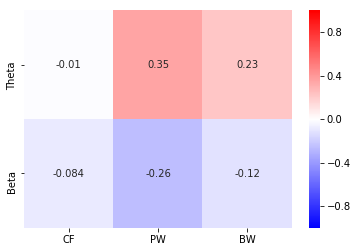

In [10]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Frontal

SpearmanrResult(correlation=0.026537403075265326, pvalue=0.699494415794208)
SpearmanrResult(correlation=-0.07664352112384894, pvalue=0.09663649271896395)
SpearmanrResult(correlation=0.41812649424038256, pvalue=1.8258465014196318e-10)
SpearmanrResult(correlation=-0.32689492168568157, pvalue=3.427048433555829e-13)
SpearmanrResult(correlation=0.16438772249354452, pvalue=0.01607981197277514)
SpearmanrResult(correlation=-0.12406209496500632, pvalue=0.007023475825915103)
SpearmanrResult(correlation=0.7123548301930058, pvalue=2.7105688814659762e-76)
SpearmanrResult(correlation=0.6547698162506036, pvalue=1.0492076011873656e-60)
SpearmanrResult(correlation=-0.5704264478434629, pvalue=3.3000472047927283e-43)
The corr of TBR to Exp is 0.71
The corr of TBR to Off is 0.65
The corr of TBR to Age is -0.57


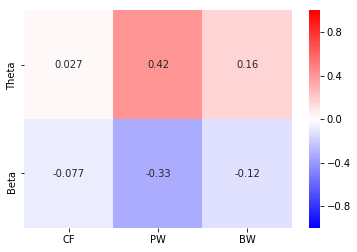

In [11]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Central

SpearmanrResult(correlation=-0.10506875544904609, pvalue=0.11604190409565704)
SpearmanrResult(correlation=-0.11630541433418815, pvalue=0.012847631817849894)
SpearmanrResult(correlation=0.3123019384745049, pvalue=1.7661116682993922e-06)
SpearmanrResult(correlation=-0.15259715440551158, pvalue=0.0010663657815791)
SpearmanrResult(correlation=0.2393037828155758, pvalue=0.00029195395804684)
SpearmanrResult(correlation=-0.13829546765586742, pvalue=0.0030508198431254286)
SpearmanrResult(correlation=0.7871623778262782, pvalue=1.3359844146248706e-102)
SpearmanrResult(correlation=0.7289061084704237, pvalue=7.5250488094932e-81)
SpearmanrResult(correlation=-0.6430942260735631, pvalue=1.7367703702374113e-57)
The corr of TBR to Exp is 0.79
The corr of TBR to Off is 0.73
The corr of TBR to Age is -0.64


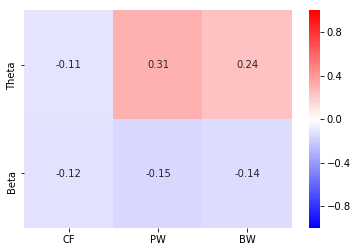

In [12]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Parietal

SpearmanrResult(correlation=0.08497771479309094, pvalue=0.24372879963133426)
SpearmanrResult(correlation=-0.10340524354395912, pvalue=0.024973306072937847)
SpearmanrResult(correlation=0.3823581641713359, pvalue=5.211196491032835e-08)
SpearmanrResult(correlation=-0.35112176518911653, pvalue=4.40036051326251e-15)
SpearmanrResult(correlation=0.16786018183745507, pvalue=0.02061430284026363)
SpearmanrResult(correlation=-0.22995855708581273, pvalue=4.6600714809116796e-07)
SpearmanrResult(correlation=0.73808458370045, pvalue=1.024662051611738e-83)
SpearmanrResult(correlation=0.7349207244823109, pvalue=1.1739089289789453e-82)
SpearmanrResult(correlation=-0.6299785602500033, pvalue=1.901110886797472e-54)
The corr of TBR to Exp is 0.74
The corr of TBR to Off is 0.73
The corr of TBR to Age is -0.63


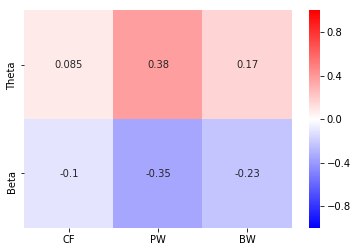

In [13]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"], save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### TAR

### Global

SpearmanrResult(correlation=-0.30848405210170265, pvalue=5.424493330385859e-104)
SpearmanrResult(correlation=-0.15321692161821468, pvalue=1.780477067599699e-55)
SpearmanrResult(correlation=-0.1835511070726774, pvalue=7.88907553254602e-37)
SpearmanrResult(correlation=-0.8937999814196274, pvalue=0.0)
SpearmanrResult(correlation=-0.006333730097578707, pvalue=0.664478921201644)
SpearmanrResult(correlation=-0.1988107378173101, pvalue=6.992287298970602e-93)
SpearmanrResult(correlation=0.15784972573852782, pvalue=1.4454128484509228e-60)
SpearmanrResult(correlation=0.13842843888327577, pvalue=7.317922091001838e-47)
SpearmanrResult(correlation=-0.3128364612419722, pvalue=3.111147788583773e-241)
The corr of TAR to Exp is 0.16
The corr of TAR to Off is 0.14
The corr of TAR to Age is -0.31


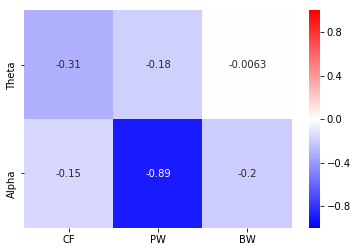

In [14]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Frontal

SpearmanrResult(correlation=-0.4636022175216043, pvalue=8.422765096794262e-13)
SpearmanrResult(correlation=-0.12979168556383586, pvalue=0.005060729138703546)
SpearmanrResult(correlation=-0.23317221302166402, pvalue=0.0005848219912163295)
SpearmanrResult(correlation=-0.8950257081067664, pvalue=1.8426751392496986e-164)
SpearmanrResult(correlation=-0.0017046164311011172, pvalue=0.9802221828030346)
SpearmanrResult(correlation=-0.24698994194733312, pvalue=6.83187132491443e-08)
SpearmanrResult(correlation=0.19848142994034904, pvalue=1.0641588237105898e-05)
SpearmanrResult(correlation=0.2366374354815467, pvalue=1.3419221936657404e-07)
SpearmanrResult(correlation=-0.3339043374381472, pvalue=4.2751940700770107e-14)
The corr of TAR to Exp is 0.20
The corr of TAR to Off is 0.24
The corr of TAR to Age is -0.33


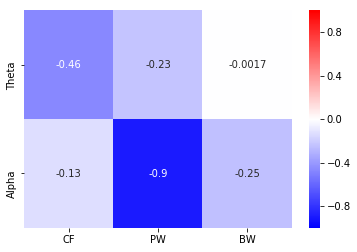

In [15]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Central

SpearmanrResult(correlation=-0.26974839272215534, pvalue=4.1324366298198126e-05)
SpearmanrResult(correlation=-0.07764886869930836, pvalue=0.09267666587933947)
SpearmanrResult(correlation=-0.12096291613990731, pvalue=0.07014189950157446)
SpearmanrResult(correlation=-0.8810670863058339, pvalue=2.8352708727118368e-154)
SpearmanrResult(correlation=0.08369387766569719, pvalue=0.21107639518379848)
SpearmanrResult(correlation=-0.2551180448007403, pvalue=2.0328674587657494e-08)
SpearmanrResult(correlation=0.2145619646138318, pvalue=2.04540465988157e-06)
SpearmanrResult(correlation=0.2937983626780307, pvalue=4.9532665214883735e-11)
SpearmanrResult(correlation=-0.3483127223314698, pvalue=3.635136386407677e-15)
The corr of TAR to Exp is 0.21
The corr of TAR to Off is 0.29
The corr of TAR to Age is -0.35


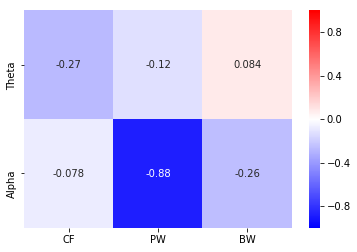

In [16]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Parietal

SpearmanrResult(correlation=-0.45068780152825355, pvalue=6.80484896619611e-11)
SpearmanrResult(correlation=-0.241065116076084, pvalue=1.1828572849059552e-07)
SpearmanrResult(correlation=-0.2636005371194129, pvalue=0.00023811686684219971)
SpearmanrResult(correlation=-0.894491238305682, pvalue=4.441097326124519e-166)
SpearmanrResult(correlation=-0.09115941767451813, pvalue=0.21098551882449945)
SpearmanrResult(correlation=-0.14540760843896247, pvalue=0.0015553077581978991)
SpearmanrResult(correlation=0.17700478300687067, pvalue=9.671214731021577e-05)
SpearmanrResult(correlation=0.19112821670232943, pvalue=2.4932031839329893e-05)
SpearmanrResult(correlation=-0.3678553423839701, pvalue=7.933376240672311e-17)
The corr of TAR to Exp is 0.18
The corr of TAR to Off is 0.19
The corr of TAR to Age is -0.37


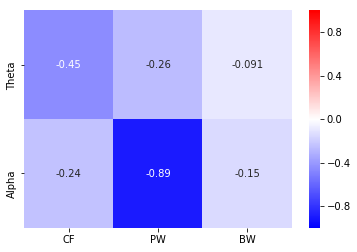

In [17]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

# ABR

### Global

SpearmanrResult(correlation=-0.26442608075376944, pvalue=2.272494483416143e-165)
SpearmanrResult(correlation=-0.08412540922672725, pvalue=9.209100975779661e-18)
SpearmanrResult(correlation=0.0018067572817925632, pvalue=0.8540750579070814)
SpearmanrResult(correlation=-0.2550372798950505, pvalue=9.561665489959044e-154)
SpearmanrResult(correlation=0.00876276566922399, pvalue=0.3723742688808912)
SpearmanrResult(correlation=-0.1152939026308864, pvalue=4.831251619175502e-32)
SpearmanrResult(correlation=0.7284222555134583, pvalue=0.0)
SpearmanrResult(correlation=0.6730206898089981, pvalue=0.0)
SpearmanrResult(correlation=-0.6089315099546881, pvalue=0.0)
The corr of ABR to Exp is 0.73
The corr of ABR to Off is 0.67
The corr of ABR to Age is -0.61


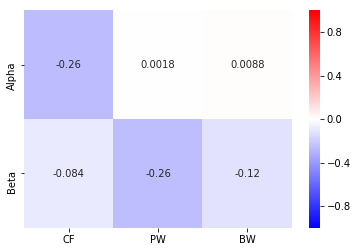

In [18]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Frontal

SpearmanrResult(correlation=-0.26281908367427803, pvalue=8.736635161650534e-09)
SpearmanrResult(correlation=-0.07664352112384894, pvalue=0.09663649271896395)
SpearmanrResult(correlation=0.010555958695164395, pvalue=0.820407515992206)
SpearmanrResult(correlation=-0.32689492168568157, pvalue=3.427048433555829e-13)
SpearmanrResult(correlation=0.005940270394123491, pvalue=0.8983456251057095)
SpearmanrResult(correlation=-0.12406209496500632, pvalue=0.007023475825915103)
SpearmanrResult(correlation=0.7123548301930058, pvalue=2.7105688814659762e-76)
SpearmanrResult(correlation=0.6547698162506036, pvalue=1.0492076011873656e-60)
SpearmanrResult(correlation=-0.5704264478434629, pvalue=3.3000472047927283e-43)
The corr of ABR to Exp is 0.71
The corr of ABR to Off is 0.65
The corr of ABR to Age is -0.57


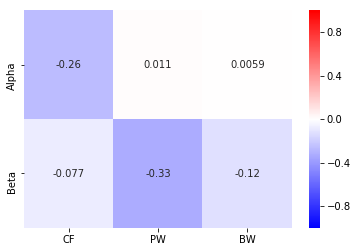

In [19]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Central

SpearmanrResult(correlation=-0.18116813373744606, pvalue=7.818207899798797e-05)
SpearmanrResult(correlation=-0.11630541433418815, pvalue=0.012847631817849894)
SpearmanrResult(correlation=0.053521157690917386, pvalue=0.2468430256504205)
SpearmanrResult(correlation=-0.15259715440551158, pvalue=0.0010663657815791)
SpearmanrResult(correlation=-0.03567884537249162, pvalue=0.44030104352685284)
SpearmanrResult(correlation=-0.13829546765586742, pvalue=0.0030508198431254286)
SpearmanrResult(correlation=0.7871623778262782, pvalue=1.3359844146248706e-102)
SpearmanrResult(correlation=0.7289061084704237, pvalue=7.5250488094932e-81)
SpearmanrResult(correlation=-0.6430942260735631, pvalue=1.7367703702374113e-57)
The corr of ABR to Exp is 0.79
The corr of ABR to Off is 0.73
The corr of ABR to Age is -0.64


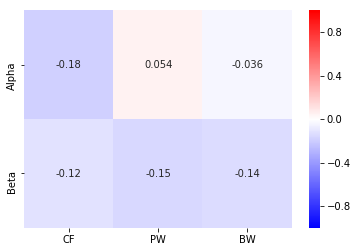

In [20]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Parietal

SpearmanrResult(correlation=-0.34538176363983, pvalue=1.2154857158825953e-14)
SpearmanrResult(correlation=-0.10340524354395912, pvalue=0.024973306072937847)
SpearmanrResult(correlation=-0.04877262777327322, pvalue=0.29082854261909313)
SpearmanrResult(correlation=-0.35112176518911653, pvalue=4.40036051326251e-15)
SpearmanrResult(correlation=0.037734375545075693, pvalue=0.4139018225570993)
SpearmanrResult(correlation=-0.22995855708581273, pvalue=4.6600714809116796e-07)
SpearmanrResult(correlation=0.73808458370045, pvalue=1.024662051611738e-83)
SpearmanrResult(correlation=0.7349207244823109, pvalue=1.1739089289789453e-82)
SpearmanrResult(correlation=-0.6299785602500033, pvalue=1.901110886797472e-54)
The corr of ABR to Exp is 0.74
The corr of ABR to Off is 0.73
The corr of ABR to Age is -0.63


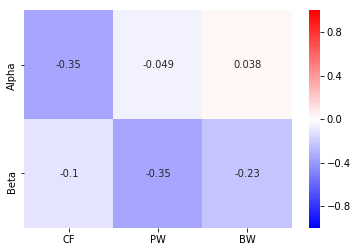

In [21]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)